🔴 Limites identifiées avec la librairie Surprise: <br>
1. Pas adaptée aux interactions implicites : Surprise est conçue pour la prédiction de notes explicites (par exemple des étoiles), alors que ton cas d’usage repose sur des clics, donc des interactions implicites.<br>
Même avec une transformation des clics en notes (par binarisation ou pondération), cela reste une approximation.<br>
2. Représentation utilisateur-article limitée : Il faut convertir manuellement les données en format (user, item, rating) et Surprise ne gère pas nativement des représentations complexes comme des embeddings.<br>
3. Pas de gestion de négatifs implicites réalistes : Les évaluations reposent sur un ensemble de test positif uniquement, ce qui limite la pertinence des métriques de type ranking (Hit Rate, NDCG, MAP). Il est difficile d’implémenter une stratégie réaliste de négatifs (non-cliqués) dans le pipeline natif de Surprise.<br>
4. Pas optimisé pour la scalabilité : Même si utilisable sur des jeux de données de taille moyenne, Surprise n’est pas conçu pour du calcul distribué ou GPU, ce qui le rend peu performant sur des grands volumes.<br>

🧠 Surprise (ex : SVD, KNN, etc.)
✅ Principe général :
Surprise travaille sur une matrice utilisateur–article de notes explicites (ex : 1 à 5 étoiles).
Objectif : prédire une note inconnue r^uir^ui​ pour un utilisateur uu et un item ii, à partir de ceux qu’il a déjà notés.

🧮 Exemple avec SVD :
La prédiction est donnée par :
$r_{ui} = \mu + b_u + b_i + q_i^T p_u$

$\mu$ : moyenne globale des notes

$b_u$, $b_i$ : biais utilisateur et article

$p_u$, $q_i$ : vecteurs latents (embeddings) appris pour chaque utilisateur et article

Optimisation par descente de gradient sur la minimisation de l’erreur de prédiction (type RMSE).

✅ Ce que la librairie implicit apporte de plus:
1. Conçue pour les interactions implicites : Implicit propose des algorithmes optimisés pour les clics, vues, achats, etc. Elle exploite l’absence de données comme un signal (via la factorisation avec poids).
2. Support natif de la pondération implicite : Elle utilise le modèle de confidence pour pondérer les interactions positives et prendre en compte le silence (cf. Hu et al., 2008).
3. Métriques de ranking adaptées : Elle permet facilement de calculer des métriques de recommandation comme Hit@k, NDCG@k, MAP@k, adaptées au contexte implicite.
4. Performances et scalabilité : Implicit est rapide, parallélisée (OpenMP) et GPU-compatible via cuDF et cuPy, ce qui permet de travailler avec de grands datasets.
5. Approches variées : Elle propose plusieurs algorithmes adaptés : Alternating Least Squares (ALS), Bayesian Personalized Ranking (BPR), Logistic Matrix Factorization (LMF), etc.

⚙️ Implicit (ex : ALS, BPR, LMF)
✅ Principe général :
implicit travaille avec une matrice utilisateur–article binaire ou pondérée (ex : clics, vues, achats).
Objectif : ranger les articles par pertinence pour chaque utilisateur, sans chercher à prédire une note.

🧮 Exemple avec ALS (Alternating Least Squares) :

On part d’une matrice de confiance $C_{ui}=1+α⋅r_{ui}$, où $r_{ui}$ est le nombre de clics ou un score pondéré.
Le modèle cherche à approximer :

$
C_{ui} \cdot (P_{ui} - x_u^T y_i)^2 
$

où :

$P_{ui}=1$ si interaction, sinon 0 <br>
$x_u,y_i$ : vecteurs latents utilisateur et article

Optimisation alternée (ALS) ou ranking direct (BPR) selon l’algorithme.



| Critère              | Surprise                 | Implicit                     |
| -------------------- | ------------------------ | ---------------------------- |
| Type d’interactions  | Explicites (notes)       | Implicites (clics, vues)     |
| Gestion des négatifs | Limité                   | Native et réaliste           |
| Métriques ranking    | Non prises en charge     | Incluses                     |
| Scalabilité          | Faible                   | Bonne (multi-thread, GPU)    |
| Cas d’usage adapté   | Films notés, évaluations | Clics articles, achats, vues |


# Filtrage collaboratif avec Implicit
On va utiliser la version qui travaille avec le GPU

In [1]:
! nvidia-smi

Sun May  4 06:12:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   40C    P5              6W /   80W |      94MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Données

### Chargement du dataframe global

In [2]:
import pandas as pd

df_clicks = pd.read_parquet("./data/df_final.parquet")
print("✅ Dataset rechargé avec succès.")

✅ Dataset rechargé avec succès.


In [3]:
df_clicks.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,...,31,32,33,34,35,36,37,38,39,40
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,...,-0.321484,0.910162,-0.413011,0.680835,-0.418409,-0.526443,0.305625,-0.307805,-0.606366,-0.650556
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,...,-1.001013,0.797471,-0.492230,-0.305857,-1.307835,0.354010,0.696917,-0.486316,0.017210,-1.563045
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,...,-0.269690,0.873445,0.194144,0.056367,-0.431036,-0.020383,-0.376942,0.814494,0.709722,-1.030146
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,...,0.144034,-2.457183,-1.500929,-1.807169,-0.208940,-0.671638,-0.407914,2.561696,-1.379031,-1.877568
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,...,-1.163678,-0.230112,-2.132536,-0.729996,0.581913,-0.559910,-0.354824,-0.914158,-0.064399,-0.354175


### Liste des articles

In [4]:
df_articles = pd.read_csv("./data/articles_with_popularity.csv", encoding='utf-8')
df_articles

,article_id,category_id,created_at_ts,publisher_id,words_count,cluster,publish_time_dt,nb_clics,popularite_tag,popularity_norm
0,0,0,1513144419000,0,168,16,2017-12-13 05:53:39,0,jamais_cliqué,0.000000
1,1,1,1405341936000,0,189,11,2014-07-14 12:45:36,0,jamais_cliqué,0.000000
2,2,1,1408667706000,0,250,3,2014-08-22 00:35:06,0,jamais_cliqué,0.000000
3,3,1,1408468313000,0,230,3,2014-08-19 17:11:53,1,banal,0.000027
4,4,1,1407071171000,0,162,3,2014-08-03 13:06:11,0,jamais_cliqué,0.000000
...,...,...,...,...,...,...,...,...,...,...
364042,364042,460,1434034118000,0,144,2,2015-06-11 14:48:38,0,jamais_cliqué,0.000000
364043,364043,460,1434148472000,0,463,7,2015-06-12 22:34:32,8,banal,0.000215
364044,364044,460,1457974279000,0,177,6,2016-03-14 16:51:19,0,jamais_cliqué,0.000000
364045,364045,460,1515964737000,0,126,1,2018-01-14 21:18:57,0,jamais_cliqué,0.000000


### Chargement des embeddings réduits

In [5]:
import pandas as pd

embeddings_df = pd.read_parquet('./data/articles_embeddings_pca.parquet')
print(embeddings_df.shape)

(364047, 41)


In [6]:
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
article_id,,,,,,,,,,,,,,,,,,,,,
0,-1.854453,-5.592402,1.708724,-3.835164,1.415795,0.252210,0.426074,0.545480,-0.807394,1.520171,...,0.387738,-0.088799,0.990514,1.060148,-0.218378,-1.099852,-1.175524,1.370632,-0.264816,0.010117
1,-5.361997,4.122991,-2.357516,-3.428017,-0.431079,3.722260,2.389835,-1.267244,1.944162,2.980629,...,0.025565,-0.721510,0.649929,-0.405225,-0.090690,-3.094968,0.075186,0.245235,-1.250343,0.294538
2,-3.600085,-0.132112,-6.027451,0.985617,0.211965,4.591712,-1.815688,-2.170389,-2.783090,2.804910,...,0.565647,-1.862223,-0.336458,0.072410,0.241466,-0.877634,0.154883,1.133963,0.946740,-1.811314
3,-1.158963,7.293352,-5.916713,-1.370524,2.172241,-1.682487,1.070822,-2.160001,1.947324,4.069597,...,0.074049,-0.612824,-1.511408,1.071736,1.991838,-2.076190,-1.690459,-1.122692,0.714619,-1.576244
4,-1.142884,2.569328,-2.891860,-0.273997,2.913007,5.608970,0.308953,0.310888,-1.054171,2.158180,...,-1.527867,-0.155615,-0.163345,0.037253,1.173636,-4.232923,-1.287476,1.053438,-0.486085,-0.144550


In [7]:
# conversion des embeddings en tableau NumPy (évite de calculer la matrice de similarité complète)
import numpy as np
article_ids = embeddings_df.index.to_numpy()
article_embeddings = embeddings_df.to_numpy()

# dictionnaire article_id -> vecteur
embedding_dict = dict(zip(article_ids, article_embeddings))

## Préparation des données pour Implicit

### Filtrage des utilisateurs
On va se limiter aux utilisateurs ayant effectué plus de 2 clics, implicit a besoin d'un minimum d'interaction pour apprendre et il est contre-productif de rajouter de la sparsité à la matrice item-user

In [8]:
user_article_clicks = df_clicks.groupby(['user_id', 'click_article_id']).size().reset_index(name='click_count')
# Filtrage des utilisateurs
articles_per_user = user_article_clicks.groupby('user_id')['click_article_id'].nunique()
filtered_users = articles_per_user[articles_per_user >= 3].index
# Application du filtre
df = user_article_clicks[user_article_clicks['user_id'].isin(filtered_users)]

### Création de la matrice item-user
On a simplement ignoré les articles non cliqués.

In [9]:
from scipy.sparse import coo_matrix
from tqdm import tqdm
import numpy as np

def build_item_user_matrix(df_clicks, weighting="log", alpha=40.0):
    """
    Construit une matrice CSR (articles × utilisateurs) compatible avec implicit,
    avec un remapping sécurisé et une pondération logarithmique ou linéaire.

    Paramètres :
    - df_clicks : DataFrame contenant 'user_id' et 'click_article_id'
    - weighting : 'log' (default) ou 'linear'
    - alpha : coefficient multiplicateur pour la pondération log

    Retourne :
    - item_user_matrix : matrice CSR (n_items x n_users)
    - user_mapping : dict {user_id → user_idx}
    - item_mapping : dict {click_article_id → item_idx}
    """

    # Agrégation des interactions
    df_user_item = (
        df_clicks.groupby(['user_id', 'click_article_id'])
        .size()
        .reset_index(name='click_strength')
    )

    # Création des mappings
    print("🔄 Construction des dictionnaires d’indexation...")
    user_ids = df_user_item['user_id'].unique()
    item_ids = df_user_item['click_article_id'].unique()

    user_mapping = {uid: idx for idx, uid in enumerate(tqdm(user_ids, desc="🔢 Mapping users"))}
    item_mapping = {iid: idx for idx, iid in enumerate(tqdm(item_ids, desc="🧾 Mapping articles"))}

    df_user_item['user_idx'] = df_user_item['user_id'].map(user_mapping)
    df_user_item['item_idx'] = df_user_item['click_article_id'].map(item_mapping)

    # Pondération
    if weighting == "log":
        df_user_item['weight'] = 1.0 + alpha * np.log1p(df_user_item['click_strength'])
        print(f"🧮 Pondération logarithmique avec alpha={alpha}")
    elif weighting == "linear":
        df_user_item['weight'] = df_user_item['click_strength'].astype(float)
        print("🧮 Pondération linéaire")
    else:
        raise ValueError("Le paramètre 'weighting' doit être 'log' ou 'linear'.")

    # Construction de la matrice sparse
    print("📐 Construction de la matrice sparse (CSR)...")
    item_user_matrix = coo_matrix(
        (df_user_item['weight'],
         (df_user_item['item_idx'], df_user_item['user_idx']))
    ).tocsr()

    # Dictionnaires pour retrouver les indices d'origine
    inv_user_mapping = {v: k for k, v in user_mapping.items()}
    inv_item_mapping = {v: k for k, v in item_mapping.items()}

    print(f"✅ Matrice prête : {item_user_matrix.shape} (articles × utilisateurs)")
    return item_user_matrix, user_mapping, item_mapping, inv_user_mapping, inv_item_mapping


In [10]:
item_user_matrix, user_mapping, item_mapping, inv_user_mapping, inv_item_mapping = build_item_user_matrix(df)

🔄 Construction des dictionnaires d’indexation...


🧾 Mapping articles: 100%|██████████| 41367/41367 [00:00<00:00, 4135225.07it/s]


🧮 Pondération logarithmique avec alpha=40.0
📐 Construction de la matrice sparse (CSR)...
✅ Matrice prête : (41367, 221379) (articles × utilisateurs)


### Visualisation de la matrice item-user

In [11]:
import matplotlib.pyplot as plt

def plot_sparse_matrix_density(sparse_matrix, title="Matrice sparse (articles × utilisateurs)"):
    plt.figure(figsize=(10, 6))
    plt.spy(sparse_matrix, markersize=0.5)
    plt.title(title)
    plt.xlabel("Utilisateurs")
    plt.ylabel("Articles")
    plt.grid(True)
    plt.show()


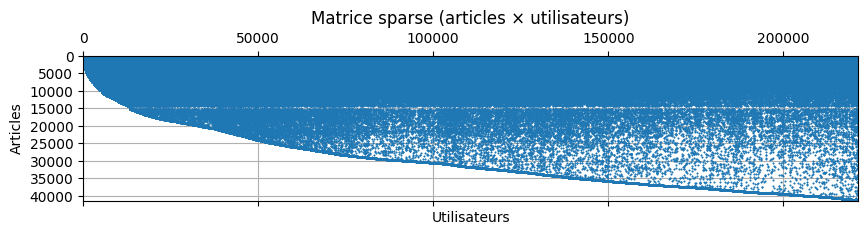

In [12]:
plot_sparse_matrix_density(item_user_matrix)

<div style="padding: 10px; border-radius: 5px; background-color: #e7f3fe; color: #31708f; border-left: 6px solid #2196F3;">
ℹ️ <strong>Explication :</strong> La répartition des données dans la matrice reflète le fait que l'on a enregistré les clics selon le temps, les utilisateurs et les articles s'accumulent petit à petit (pas de shuffle lors du mappage des index)
</div>

In [13]:
def print_matrix_density(sparse_matrix):
    n_total = sparse_matrix.shape[0] * sparse_matrix.shape[1]
    n_nonzero = sparse_matrix.nnz
    density = n_nonzero / n_total * 100

    print(f"📦 Taux de remplissage : {n_nonzero:,} éléments non nuls")
    print(f"📐 Dimensions         : {sparse_matrix.shape}")
    print(f"📊 Densité            : {density:.6f}%")

In [14]:
print_matrix_density(item_user_matrix)

📦 Taux de remplissage : 2,747,674 éléments non nuls
📐 Dimensions         : (41367, 221379)
📊 Densité            : 0.030004%


<div style="padding: 10px; border-radius: 5px; background-color: #e7f3fe; color: #31708f; border-left: 6px solid #2196F3;">
ℹ️ <strong>Explication :</strong> Chaque cellule non nulle correspond à au moins un clic, toutes les cellules vides sont des non-observations. Pas besoin de créer du sampling négatif ALS ou BPR sont conçus pour modéliser les interactions positives Et l'absence d'interaction comme une faible préférence implicite
</div>

## Mise en oeuvre du modèle ALS (Alternative Least Squares)

In [16]:
import time
from implicit.gpu.als import AlternatingLeastSquares

# Paramètres
factors = 128
iterations = 30
regularization = 0.1

# Modèle ALS GPU
model = AlternatingLeastSquares(
    factors=factors,
    regularization=regularization,
    iterations=iterations
)

# Entraînement
print("⏱️ Entraînement ALS en cours...")
start = time.time()
model.fit(item_user_matrix)
end = time.time()
print(f"✅ Modèle entraîné en {end - start:.2f} secondes")


⏱️ Entraînement ALS en cours...


100%|██████████| 30/30 [00:03<00:00,  8.45it/s]

✅ Modèle entraîné en 3.63 secondes


### 💡 Vérification rapide du traitement après entrainement-test

In [17]:
def get_recommendations_for_user(
    user_id,
    model,
    item_user_matrix,
    user_mapping,
    reverse_item_mapping,
    df_clicks,
    N=5
):
    """
    Renvoie les recommandations d'articles pour un utilisateur donné.

    Paramètres :
    - user_id : identifiant de l'utilisateur (origine des données)
    - model : modèle ALS entraîné (implicit.gpu ou cpu)
    - item_user_matrix : matrice CSR article x utilisateur
    - user_mapping : dict {user_id → user_idx}
    - reverse_item_mapping : dict {item_idx → click_article_id}
    - df_clicks : DataFrame original pour extraire les clics réels
    - N : nombre de recommandations à retourner

    Retourne :
    - clicked_article_ids : liste des articles réellement cliqués
    - recommended_articles : liste de tuples (click_article_id, score)
    """

    # Vérifie que l'utilisateur est connu
    if user_id not in user_mapping:
        raise ValueError(f"L'utilisateur {user_id} n'est pas présent dans le mapping.")

    user_idx = user_mapping[user_id]

    # Extraire les articles cliqués
    clicked_article_ids = df_clicks[df_clicks['user_id'] == user_id]['click_article_id'].unique().tolist()

    # Extraire une ligne CSR (1, n_items)
    user_items = item_user_matrix.T.tocsr()
    user_row = user_items[user_idx:user_idx+1]

    # Recommandations
    recommended = model.recommend(
        userid=user_idx,
        user_items=user_row,
        N=N,
        filter_already_liked_items=True # ❌ si False on garde les articles déjà cliqués
    )

    # Conversion des item_idx en click_article_id
    recommended_articles = [
        (reverse_item_mapping[int(i)], float(s)) for i, s in zip(*recommended)
        if int(i) in reverse_item_mapping
    ]

    return clicked_article_ids, recommended_articles


In [24]:
clicked, recommended = get_recommendations_for_user(
    user_id=42,
    model=model,
    item_user_matrix=item_user_matrix,
    user_mapping=user_mapping,
    reverse_item_mapping=inv_item_mapping,  
    df_clicks=df,
    N=10
)

print("📌 Articles cliqués :", clicked)
print("⭐ Articles recommandés :", recommended)


📌 Articles cliqués : [9126, 71608, 75825, 107216, 119193, 119534, 129434, 145166, 157861, 158541, 208518, 218028, 225019, 226595, 226648, 235854, 284178, 284346, 285331, 285414, 288457, 292594, 292749, 313996, 315146, 331116, 336220, 336221, 336380, 352902, 353673]
⭐ Articles recommandés : [(np.int32(60465), 0.5622569918632507), (np.int32(313957), 0.5003130435943604), (np.int32(235370), 0.4649291932582855), (np.int32(42888), 0.46010059118270874), (np.int32(105343), 0.4517788589000702)]


<div style="padding: 10px; border-radius: 5px; background-color: #fff4e5; color: #8a6d3b; border-left: 6px solid #ff9800;">
⚠️ <strong>On demande 10 recommandations - le système en fournit 5 :</strong> On filtre les recommandations (les articles déjà cliqués ne sont pas recommandés)
</div>

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# df_embeddings doit être un DataFrame avec index = article_id, colonnes = ["dim1", "dim2"]
# clicked_article_ids : liste des articles que l'utilisateur a cliqués
# recommended_articles : liste de tuples (article_id, score)


import matplotlib.pyplot as plt

def plot_article_recommendations(df_embeddings, clicked_article_ids, recommended_articles):
    """
    Affiche une projection 2D des articles, avec les articles recommandés et cliqués mis en valeur.

    Args:
    - df_embeddings: DataFrame avec index = article_id, colonnes = ['dim1', 'dim2']
    - clicked_article_ids: liste d'IDs d'articles cliqués par l'utilisateur
    - recommended_articles: liste de tuples (article_id, score)
    """
    df_visu = df_embeddings.reset_index().copy()

    # Sélection uniquement des articles présents dans la projection
    projected_ids = set(df_visu['article_id'])

    clicked_article_ids = [aid for aid in clicked_article_ids if aid in projected_ids]
    recommended_articles = [(aid, s) for aid, s in recommended_articles if aid in projected_ids]

    # Alerte si des éléments ne sont pas projetés
    if len(clicked_article_ids) == 0:
        print("⚠️ Aucun article cliqué n'est dans la projection.")
    if len(recommended_articles) == 0:
        print("⚠️ Aucun article recommandé n'est dans la projection.")

    # Marquage des statuts
    df_visu['status'] = 'autres'
    df_visu.loc[df_visu['article_id'].isin(clicked_article_ids), 'status'] = 'cliqué'
    for aid, _ in recommended_articles:
        if aid in clicked_article_ids:
            df_visu.loc[df_visu['article_id'] == aid, 'status'] = 'cliqué & recommandé'
        else:
            df_visu.loc[df_visu['article_id'] == aid, 'status'] = 'recommandé'

    # Taille des points via score
    score_dict = {aid: score for aid, score in recommended_articles}
    df_visu['score'] = df_visu['article_id'].map(score_dict)
    df_visu['score'] = df_visu['score'].fillna(0.1)  # visible par défaut

    # Couleurs personnalisées
    palette = {
        'autres': 'lightgray',
        'cliqué': 'blue',
        'recommandé': 'orange',
        'cliqué & recommandé': 'green'
    }

    # Affichage
    plt.figure(figsize=(10, 6))

    # Tracer les "autres" d'abord
    bg = df_visu[df_visu["status"] == "autres"]
    plt.scatter(bg['dim1'], bg['dim2'],
                s=10, c='lightgray', label='autres', alpha=0.3, edgecolors='none')

    # Tracer les autres statuts avec emphase
    for status in ["cliqué", "recommandé", "cliqué & recommandé"]:
        group = df_visu[df_visu["status"] == status]
        if not group.empty:
            plt.scatter(group['dim1'], group['dim2'],
                        s=200 * group['score'],
                        c=palette[status],
                        label=status,
                        alpha=0.9,
                        edgecolors='k',
                        linewidth=0.5,
                        zorder=3)

    plt.title("Projection 2D des articles avec recommandations et clics")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


In [26]:
# Réduction à 2 dimensions et renommage pour la visualisation
embeddings_df_2d = embeddings_df[[0, 1]].copy()
embeddings_df_2d.columns = ['dim1', 'dim2']
embeddings_df_2d.index.name = 'article_id'


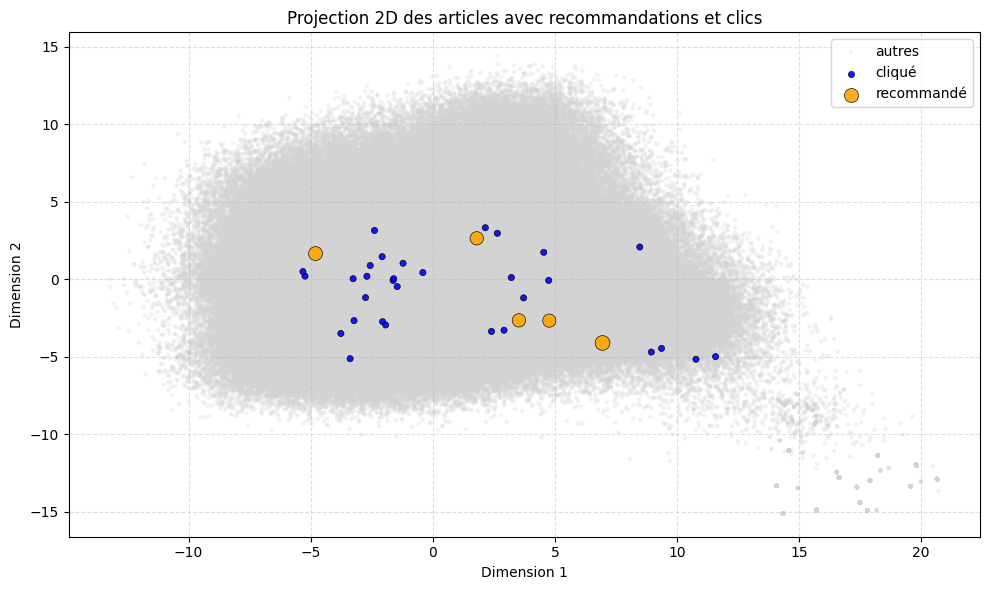

In [27]:
# 📊 Visualisation dans l'espace des embeddings
plot_article_recommendations(
    embeddings_df_2d,             # Ton DataFrame des embeddings 2D (indexé par article_id)
    clicked,       # Liste des articles cliqués par le user
    recommended       # Liste (article_id, score) des recommandations
)

### 🔁 Étape 1 : Split Leave-One-Out

In [28]:
def leave_one_out_split(item_user_matrix):
    """
    Effectue un split leave-one-out par utilisateur sur une matrice (items x users).

    Retourne :
    - train_matrix : matrice CSR (items x users)
    - test_data : liste (user_idx, item_idx)
    """
    user_item_matrix = item_user_matrix.T.tocsr()  # (users, items)
    train_matrix = user_item_matrix.copy().tolil()
    test_data = []

    print("🔄 Création du split leave-one-out...")
    for user_idx in range(user_item_matrix.shape[0]):
        user_items = user_item_matrix[user_idx].indices
        if len(user_items) < 2:
            continue

        test_item = np.random.choice(user_items)
        test_data.append((user_idx, test_item))  # ✅ ordre correct (user_idx, item_idx)
        train_matrix[user_idx, test_item] = 0

    # Transposer pour obtenir (items x users)
    train_matrix = train_matrix.tocsr().T.tocsr()

    print(f"✅ Split terminé : {len(test_data)} interactions mises de côté pour test.")
    return train_matrix, test_data


In [29]:
train_matrix, test_data = leave_one_out_split(item_user_matrix)

🔄 Création du split leave-one-out...
✅ Split terminé : 221379 interactions mises de côté pour test.


In [31]:
print("Taille train_matrix :", train_matrix.shape)
print("Nombre d'utilisateurs dans test_data :", len(set([u for u, _ in test_data])))
print("Nombre d'utilisateurs conservés dans train_matrix :", train_matrix.shape[1])


Taille train_matrix : (41367, 221379)
Nombre d'utilisateurs dans test_data : 221379
Nombre d'utilisateurs conservés dans train_matrix : 221379


In [32]:
print("Max user_idx dans test_data :", max(u for u, _ in test_data))
print("Shape model.user_factors :", model.user_factors.shape)


Max user_idx dans test_data : 221378
Shape model.user_factors : (41367, 128)


In [33]:
print("model.user_factors.shape :", model.user_factors.shape)
print("Expected users :", train_matrix.shape[1])  # doit correspondre
print("Expected items :", train_matrix.shape[0])


model.user_factors.shape : (41367, 128)
Expected users : 221379
Expected items : 41367


In [34]:
print("Exemple test_data :", test_data[:5])
print("Max user_idx :", max(u for u, _ in test_data))
print("Max item_idx :", max(i for _, i in test_data))


Exemple test_data : [(0, np.int32(2)), (1, np.int32(19)), (2, np.int32(22)), (3, np.int32(35)), (4, np.int32(42))]
Max user_idx : 221378
Max item_idx : 41366


In [35]:
max_user_idx = max(u for u, _ in test_data)
max_item_idx = max(i for _, i in test_data)

print("Max user_idx :", max_user_idx)
print("Max item_idx :", max_item_idx)
print("model.user_factors.shape[0] :", model.user_factors.shape[0])
print("model.item_factors.shape[0] :", model.item_factors.shape[0])


Max user_idx : 221378
Max item_idx : 41366
model.user_factors.shape[0] : 41367
model.item_factors.shape[0] : 221379


| Élément        | Taille / Valeur | Commentaire                                     |
| -------------- | --------------- | ----------------------------------------------- |
| `train_matrix` | (41367, 221379) | ✅ (items × users) ✔️                            |
| `test_data`    | 221379 éléments | ✅ 1 test item par utilisateur ✔️                |
| `max user_idx` | 221378          | ✅ Index max cohérent avec shape `(0–221378)` ✔️ |
| `max item_idx` | 41366           | ✅ Index max cohérent avec shape `(0–41366)` ✔️  |


| Attribut                   | Valeur        | Commentaire                                                                         |
| -------------------------- | ------------- | ----------------------------------------------------------------------------------- |
| `model.user_factors.shape` | (41367, 128)  | ✅ Ce sont les **factors des articles**, car tu as entraîné sur `(items × users)` ✔️ |
| `model.item_factors.shape` | (221379, 128) | ✅ Ce sont les **factors des utilisateurs**, dans l'ordre `user_idx` ✔️              |


<div style="padding: 10px; border-radius: 5px; background-color: #fff4e5; color: #8a6d3b; border-left: 6px solid #ff9800;">
⚠️ <strong>Important à retenir :</strong> On dirait que implicit inverse la matrice mais en fait il fonctionne avec model.user_factors ← rows = items et model.item_factors ← rows = users, et c'est logique quand on fournit une matrice items  xusers
</div>

### ⚙️ 2. Test de plusieurs algorithmes
🧠 Contruit une fonction générique :
✅ train_and_predict(model_class, params, train_matrix, test_data, N=5)

Elle doit :<br>
- Entraîner le modèle sur train_matrix
- Générer les N recommandations par utilisateur
- Comparer à test_data pour calculer les prédictions top-N
- Retourner un dictionnaire user_idx → [item_idx_1, item_idx_2, ..., item_idx_N]

In [58]:
def train_and_predict(model_class, params, train_matrix, test_data, N=5):
    """
    Entraîne un modèle implicit et génère les top-N prédictions pour chaque utilisateur.
    """
    from tqdm import tqdm

    print(f"⚙️ Entraînement du modèle {model_class.__name__}...")
    model = model_class(**params)
    model.fit(train_matrix.T)

    # Vérification optionnelle des dimensions
    if hasattr(model, "user_factors"):
        print("model.user_factors.shape :", model.user_factors.shape)
        assert model.user_factors.shape[0] == train_matrix.shape[1], "❌ Les utilisateurs ne sont pas correctement alignés"

    user_item_matrix = train_matrix.T.tocsr()  # (users x items)
    recommendations = {}

    print("🔮 Génération des recommandations top-N...")
    for user_idx, _ in tqdm(test_data, desc="📡 Prédiction"):
        try:
            if user_idx >= user_item_matrix.shape[0]:
                continue

            user_row = user_item_matrix[user_idx:user_idx+1].tocsr(copy=True)
            item_indices, _ = model.recommend(
                userid=user_idx,
                user_items=user_row,
                N=N,
                filter_already_liked_items=True
            )
            recommendations[user_idx] = item_indices
        except Exception as e:
            print(f"⚠️ Utilisateur {user_idx} ignoré : {e}")
            continue

    return model, recommendations


⚠️ Attention au piège de la matrice dans implicit.ALS !<br>
💡 Le modèle ALS de la bibliothèque `implicit` suppose que :

    - Les lignes de la matrice = les *items* à factoriser (ex : articles)
    - Les colonnes = les *utilisateurs* (chaque interaction = un clic)

    ➤ La forme attendue est : (n_items, n_users)
😱 Mais si on passe la matrice sans précaution...<br>
model.fit(train_matrix)  # ⛔ Si train_matrix est (users × items), erreur silencieuse<br>
Le modèle apprendra des user_factors… pour les articles ❌
➤ Ce qui provoque ensuite des erreurs : row index out of bounds lors des recommandations<br>
✅ Bonne pratique : forcer le bon sens<br>
model.fit(train_matrix.T)  # ✅ Toujours transposer pour garantir (items × users)<br>
🎯 Cela garantit que :

    model.user_factors.shape[0] == n_users

    model.item_factors.shape[0] == n_items

    .recommend(user_idx, ...) fonctionnera pour tous les utilisateurs

In [37]:
from implicit.gpu.als import AlternatingLeastSquares

params = {
    "factors": 128,
    "regularization": 0.1,
    "iterations": 30
}

als_model, reco_top5 = train_and_predict(
    model_class=AlternatingLeastSquares,
    params=params,
    train_matrix=train_matrix,
    test_data=test_data,
    N=5
)


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.028748273849487305 seconds
  warnings.warn(


⚙️ Entraînement du modèle AlternatingLeastSquares...


100%|██████████| 30/30 [00:03<00:00,  9.24it/s]


model.user_factors.shape : (221379, 128)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [01:25<00:00, 2585.98it/s]


In [59]:
# from implicit.nearest_neighbours import BM25Recommender

# params_bm25 = {
#     "K": 100  # nombre de voisins
# }

# bm25_model, reco_bm25 = train_and_predict(
#     model_class=BM25Recommender,
#     params=params_bm25,
#     train_matrix=train_matrix,
#     test_data=test_data,
#     N=5
# )
# from implicit.nearest_neighbours import ItemItemRecommender

# params = {
#     "K": 300
# }

# itemknn_model, reco_top5 = train_and_predict(
#     model_class=ItemItemRecommender,
#     params=params,
#     train_matrix=train_matrix,
#     test_data=test_data,
#     N=5
# )


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.027151107788085938 seconds
  warnings.warn(


⚙️ Entraînement du modèle ItemItemRecommender...


100%|██████████| 41367/41367 [00:00<00:00, 103269.56it/s]


🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [00:13<00:00, 16472.11it/s]


### 📏 Étape 3 : Calcul des métriques Top-N

In [38]:
import numpy as np

def evaluate_topn_metrics(recommendations, test_data, N=5):
    """
    Évalue les performances top-N d’un système de recommandation.

    Arguments :
    - recommendations : dict {user_idx: [item_idx1, ..., item_idxN]}
    - test_data : list of (user_idx, item_idx) ground truth
    - N : top-N à évaluer

    Retourne :
    - dict de métriques moyennes : hit, recall, precision, map, ndcg
    """
    hits, recalls, precisions, ndcgs, maps = [], [], [], [], []

    for user_idx, true_item in test_data:
        preds = recommendations.get(user_idx)
        if preds is None:
            continue

        preds = list(preds)
        
        if true_item in preds:
            rank = preds.index(true_item)
            hits.append(1)
            recalls.append(1)  # ✅ même valeur que hit en leave-one-out
            precisions.append(1 / (rank + 1))
            maps.append(1 / (rank + 1))
            ndcgs.append(1 / np.log2(rank + 2))
        else:
            hits.append(0)
            recalls.append(0)
            precisions.append(0)
            maps.append(0)
            ndcgs.append(0)

    metrics = {
        f"Hit@{N}": np.mean(hits),
        f"Recall@{N}": np.mean(recalls),  # ✅ recall est 0 ou 1 vu qu'on a fait leave-one-out donc c'est le hit !
        f"Precision@{N}": np.mean(precisions),
        f"MAP@{N}": np.mean(maps),
        f"NDCG@{N}": np.mean(ndcgs),
        "users_evaluated": len(hits)
    }
    return metrics


In [39]:
# Évaluation Top-N
topn_metrics = evaluate_topn_metrics(reco_top5, test_data, N=5)
print("📊 Top-N Metrics:")
for k, v in topn_metrics.items():
    print(f"{k.upper()}@5 : {v:.4f}")

📊 Top-N Metrics:
HIT@5@5 : 0.2230
RECALL@5@5 : 0.2230
PRECISION@5@5 : 0.1256
MAP@5@5 : 0.1256
NDCG@5@5 : 0.1496
USERS_EVALUATED@5 : 221379.0000


### 📐 Étape 4 : Calcul de MAE et RMSE à partir du modèle implicit

🔥 Sur GPU les objets model.user_factors[...] et model.item_factors[...] ne sont pas des numpy.array classiques, mais des objets implicit.gpu._cuda.Matrix.<br>
🧠 Problème : L’opérateur @ (produit scalaire) ne fonctionne pas directement sur ces objets GPU, on les passe en numpy + applatissement<br>
RMSE et MAE seront ici basés sur une vérité unique et binaire mais ce sont de bons indicateurs pour le niveau de confiance dans le modèle

In [41]:
def evaluate_prediction_error(model, test_data, user_item_matrix):
    """
    Calcule MAE et RMSE pour les paires (user, item) du test.
    
    Arguments :
    - model : modèle entraîné (ex. ALS)
    - test_data : liste (user_idx, item_idx)
    - user_item_matrix : matrice CSR (user × item), pour recalcul_user
    
    Retourne :
    - dict avec MAE et RMSE
    """
    
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    import numpy as np

    y_true = []
    y_pred = []

    for user_idx, item_idx in test_data:
        if user_idx >= model.user_factors.shape[0]:
            continue
        if item_idx >= model.item_factors.shape[0]:
            continue

        # Supporte à la fois torch, cupy et numpy
        u = model.user_factors[user_idx]
        i = model.item_factors[item_idx]

        if hasattr(u, 'to_numpy'):
            u = u.to_numpy().ravel()
        else:
            u = np.array(u).ravel()

        if hasattr(i, 'to_numpy'):
            i = i.to_numpy().ravel()
        else:
            i = np.array(i).ravel()

        score = u @ i

        y_true.append(1.0)
        y_pred.append(score)

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    return {
        "MAE": mae,
        "RMSE": rmse,
        "pairs_evaluated": len(y_true)
    }


In [42]:
# Erreurs de prédiction
# test_data_prediction_error = [(i, u) for (u, i) in test_data]
user_item_matrix = train_matrix.T.tocsr()
error_metrics = evaluate_prediction_error(als_model, test_data, user_item_matrix)
print("\n📈 Prediction Error Metrics:")
for k, v in error_metrics.items():
    print(f"{k.upper()} : {v:.4f}")


📈 Prediction Error Metrics:
MAE : 0.6501
RMSE : 0.7058
PAIRS_EVALUATED : 221379.0000


### 📊 5. Entrainement + Évaluation complète

In [43]:
def evaluate_model_metrics_only(model_class, params, train_matrix, test_data, N=5):
    """
    Entraîne un modèle implicit avec une classe + ses hyperparamètres,
    évalue les recommandations top-N + erreurs de prédiction et retourne un dict.

    Arguments :
    - model_class : classe du modèle (ex: AlternatingLeastSquares)
    - params : dictionnaire d’hyperparamètres
    - train_matrix : CSR matrix (users x items)
    - test_data : liste (user_id, item_id)
    - N : top-N à évaluer

    Retourne :
    - metrics_dict : dict {hit@N, precision@N, map@N, ndcg@N, MAE, RMSE, pairs_evaluated}
    """
    print("🔁 Entraînement du modèle et génération des prédictions...")
    model, recommendations = train_and_predict(model_class, params, train_matrix, test_data, N=N)

    print("\n📊 Évaluation Top-N :")
    topn_metrics = evaluate_topn_metrics(recommendations, test_data, N=N)
    for metric, value in topn_metrics.items():
        print(f"{metric.upper()}@{N} : {value:.4f}")

    print("\n📈 Erreurs de prédiction (MAE / RMSE) :")
    user_item_matrix = train_matrix.T.tocsr()
    error_metrics = evaluate_prediction_error(model, test_data, user_item_matrix)
    for metric, value in error_metrics.items():
        print(f"{metric.upper()} : {value:.4f}")

    metrics_dict = {
        f"{metric}@{N}": value for metric, value in topn_metrics.items()
    }
    metrics_dict.update(error_metrics)

    return metrics_dict


In [60]:
from implicit.als import AlternatingLeastSquares

params = {"factors": 50, "regularization": 0.01, "iterations": 20}
results = evaluate_model_metrics_only(AlternatingLeastSquares, params, train_matrix, test_data, N=10)


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.028189659118652344 seconds
  warnings.warn(


🔁 Entraînement du modèle et génération des prédictions...
⚙️ Entraînement du modèle AlternatingLeastSquares...


100%|██████████| 20/20 [00:01<00:00, 15.55it/s]


model.user_factors.shape : (221379, 50)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [01:20<00:00, 2738.37it/s]



📊 Évaluation Top-N :
HIT@10@10 : 0.3214
RECALL@10@10 : 0.3214
PRECISION@10@10 : 0.1316
MAP@10@10 : 0.1316
NDCG@10@10 : 0.1758
USERS_EVALUATED@10 : 221379.0000

📈 Erreurs de prédiction (MAE / RMSE) :
MAE : 0.5644
RMSE : 0.6383
PAIRS_EVALUATED : 221379.0000


## Mise en oeuvre des différents algorithmes

### 🎨 Entrainement des modèles

In [61]:
from implicit.gpu.als import AlternatingLeastSquares
from implicit.gpu.bpr import BayesianPersonalizedRanking
from implicit.cpu.lmf import LogisticMatrixFactorization
from implicit.nearest_neighbours import ItemItemRecommender

model_grids = {
    AlternatingLeastSquares: [
        {"factors": 32, "regularization": 0.1, "iterations": 10},
        {"factors": 64, "regularization": 0.05, "iterations": 15},
        {"factors": 128, "regularization": 0.01, "iterations": 20},
        {"factors": 128, "regularization": 0.2, "iterations": 20},   # ➕ modèle large fortement régularisé
        {"factors": 32, "regularization": 0.001, "iterations": 10}   # ➕ modèle léger peu régularisé
    ],

    BayesianPersonalizedRanking: [
        {"factors": 64, "regularization": 0.01, "iterations": 15},
        {"factors": 128, "regularization": 0.05, "iterations": 20},
        {"factors": 64, "regularization": 0.005, "iterations": 30},
        {"factors": 32, "regularization": 0.1, "iterations": 20},
        {"factors": 96, "regularization": 0.005, "iterations": 25},  # ➕ intermédiaire
        {"factors": 64, "regularization": 0.5, "iterations": 10}     # ➕ version très régularisée
    ],

    LogisticMatrixFactorization: [
        {"factors": 64, "regularization": 0.1, "iterations": 15},
        {"factors": 128, "regularization": 0.05, "iterations": 20},
        {"factors": 64, "regularization": 0.005, "iterations": 30},
        {"factors": 32, "regularization": 0.01, "iterations": 20},
        {"factors": 128, "regularization": 0.01, "iterations": 40},  # ➕ gros modèle avec entraînement long
        {"factors": 64, "regularization": 0.0001, "iterations": 10}  # ➕ test régularisation quasi nulle
    ],

    ItemItemRecommender: [
        {"K": 10},    # ➕ ultra personnalisé
        {"K": 50},
        {"K": 100},
        {"K": 200},
        {"K": 300},
        {"K": 500}     # ➕ test couverture max
    ]
}


In [62]:
import pandas as pd
import numpy as np

def grid_search_models(model_grids, train_matrix, test_data, N=5):
    """
    Teste plusieurs modèles et grilles d'hyperparamètres, retourne un DataFrame de résultats.
    """
    all_results = []

    for model_class, param_list in model_grids.items():
        model_name = model_class.__name__
        for params in param_list:
            print(f"\n🚀 Test : {model_name} | Params = {params}")
            try:
                model, recommendations = train_and_predict(model_class, params, train_matrix, test_data, N=N)

                # Évaluation Top-N
                topn_metrics = evaluate_topn_metrics(recommendations, test_data, N=N)
                result_row = {
                    "model": model_name,
                    **params,
                    **{f"{k}@{N}": v for k, v in topn_metrics.items()}
                }

                # Évaluation Erreurs uniquement si user/item factors disponibles
                if hasattr(model, "user_factors") and hasattr(model, "item_factors"):
                    try:
                        user_item_matrix = train_matrix.T.tocsr()
                        error_metrics = evaluate_prediction_error(model, test_data, user_item_matrix)
                        result_row.update(error_metrics)
                    except Exception as e:
                        print(f"⚠️ Erreur dans evaluate_prediction_error : {e}")
                        result_row.update({
                            "MAE": np.nan,
                            "RMSE": np.nan,
                            "pairs_evaluated": np.nan
                        })
                else:
                    print(f"⚠️ {model_name} ne supporte pas l'évaluation d'erreurs (pas de facteurs latents)")
                    result_row.update({
                        "MAE": np.nan,
                        "RMSE": np.nan,
                        "pairs_evaluated": np.nan
                    })

                all_results.append(result_row)

            except Exception as e:
                print(f"❌ Erreur pour {model_name} avec {params} : {e}")
                continue

    df_results = pd.DataFrame(all_results)

    # Tri par MAP si présent
    sort_column = f"MAP@{N}" if f"MAP@{N}" in df_results.columns else None
    if sort_column:
        df_results = df_results.sort_values(by=sort_column, ascending=False)

    return df_results.reset_index(drop=True)


In [63]:
N = 5

In [64]:
df_grid_results = grid_search_models(model_grids, train_matrix, test_data, N=N)

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.02614307403564453 seconds
  warnings.warn(



🚀 Test : AlternatingLeastSquares | Params = {'factors': 32, 'regularization': 0.1, 'iterations': 10}
⚙️ Entraînement du modèle AlternatingLeastSquares...


100%|██████████| 10/10 [00:00<00:00, 26.81it/s]


model.user_factors.shape : (221379, 32)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [01:17<00:00, 2850.33it/s]
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.024919748306274414 seconds
  warnings.warn(



🚀 Test : AlternatingLeastSquares | Params = {'factors': 64, 'regularization': 0.05, 'iterations': 15}
⚙️ Entraînement du modèle AlternatingLeastSquares...


100%|██████████| 15/15 [00:00<00:00, 15.53it/s]


model.user_factors.shape : (221379, 64)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [01:23<00:00, 2648.32it/s]
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.019078969955444336 seconds
  warnings.warn(



🚀 Test : AlternatingLeastSquares | Params = {'factors': 128, 'regularization': 0.01, 'iterations': 20}
⚙️ Entraînement du modèle AlternatingLeastSquares...


100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


model.user_factors.shape : (221379, 128)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [01:19<00:00, 2783.56it/s]
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.020731687545776367 seconds
  warnings.warn(



🚀 Test : AlternatingLeastSquares | Params = {'factors': 128, 'regularization': 0.2, 'iterations': 20}
⚙️ Entraînement du modèle AlternatingLeastSquares...


100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


model.user_factors.shape : (221379, 128)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [01:21<00:00, 2720.09it/s]
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.019647598266601562 seconds
  warnings.warn(



🚀 Test : AlternatingLeastSquares | Params = {'factors': 32, 'regularization': 0.001, 'iterations': 10}
⚙️ Entraînement du modèle AlternatingLeastSquares...


100%|██████████| 10/10 [00:00<00:00, 26.11it/s]


model.user_factors.shape : (221379, 32)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [01:18<00:00, 2831.40it/s]
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.020936250686645508 seconds
  warnings.warn(



🚀 Test : BayesianPersonalizedRanking | Params = {'factors': 64, 'regularization': 0.01, 'iterations': 15}
⚙️ Entraînement du modèle BayesianPersonalizedRanking...


100%|██████████| 15/15 [00:00<00:00, 46.07it/s, train_auc=53.53%, skipped=5.28%]


model.user_factors.shape : (221379, 65)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [01:26<00:00, 2573.91it/s]



🚀 Test : BayesianPersonalizedRanking | Params = {'factors': 128, 'regularization': 0.05, 'iterations': 20}
⚙️ Entraînement du modèle BayesianPersonalizedRanking...


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.0204010009765625 seconds
  warnings.warn(
100%|██████████| 20/20 [00:00<00:00, 28.84it/s, train_auc=52.65%, skipped=5.28%]


model.user_factors.shape : (221379, 129)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [01:21<00:00, 2726.77it/s]
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.02095961570739746 seconds
  warnings.warn(



🚀 Test : BayesianPersonalizedRanking | Params = {'factors': 64, 'regularization': 0.005, 'iterations': 30}
⚙️ Entraînement du modèle BayesianPersonalizedRanking...


100%|██████████| 30/30 [00:00<00:00, 48.78it/s, train_auc=83.80%, skipped=5.25%]


model.user_factors.shape : (221379, 65)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [01:27<00:00, 2543.86it/s]
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.021766185760498047 seconds
  warnings.warn(



🚀 Test : BayesianPersonalizedRanking | Params = {'factors': 32, 'regularization': 0.1, 'iterations': 20}
⚙️ Entraînement du modèle BayesianPersonalizedRanking...


100%|██████████| 20/20 [00:00<00:00, 69.89it/s, train_auc=53.20%, skipped=5.28%]


model.user_factors.shape : (221379, 33)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [01:19<00:00, 2795.49it/s]
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.020673751831054688 seconds
  warnings.warn(



🚀 Test : BayesianPersonalizedRanking | Params = {'factors': 96, 'regularization': 0.005, 'iterations': 25}
⚙️ Entraînement du modèle BayesianPersonalizedRanking...


100%|██████████| 25/25 [00:00<00:00, 36.41it/s, train_auc=80.05%, skipped=5.27%]


model.user_factors.shape : (221379, 97)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [01:28<00:00, 2495.23it/s]
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.019979238510131836 seconds
  warnings.warn(



🚀 Test : BayesianPersonalizedRanking | Params = {'factors': 64, 'regularization': 0.5, 'iterations': 10}
⚙️ Entraînement du modèle BayesianPersonalizedRanking...


100%|██████████| 10/10 [00:00<00:00, 44.83it/s, train_auc=52.57%, skipped=5.26%]


model.user_factors.shape : (221379, 65)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [01:32<00:00, 2388.06it/s]



🚀 Test : LogisticMatrixFactorization | Params = {'factors': 64, 'regularization': 0.1, 'iterations': 15}
⚙️ Entraînement du modèle LogisticMatrixFactorization...


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.015192985534667969 seconds
  warnings.warn(
100%|██████████| 15/15 [00:09<00:00,  1.64it/s]


model.user_factors.shape : (221379, 66)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [00:58<00:00, 3805.92it/s]



🚀 Test : LogisticMatrixFactorization | Params = {'factors': 128, 'regularization': 0.05, 'iterations': 20}
⚙️ Entraînement du modèle LogisticMatrixFactorization...


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.01619720458984375 seconds
  warnings.warn(
100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


model.user_factors.shape : (221379, 130)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [01:41<00:00, 2176.38it/s]
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.015917539596557617 seconds
  warnings.warn(



🚀 Test : LogisticMatrixFactorization | Params = {'factors': 64, 'regularization': 0.005, 'iterations': 30}
⚙️ Entraînement du modèle LogisticMatrixFactorization...


100%|██████████| 30/30 [00:17<00:00,  1.67it/s]


model.user_factors.shape : (221379, 66)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [01:02<00:00, 3560.21it/s]
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.016102313995361328 seconds
  warnings.warn(



🚀 Test : LogisticMatrixFactorization | Params = {'factors': 32, 'regularization': 0.01, 'iterations': 20}
⚙️ Entraînement du modèle LogisticMatrixFactorization...


100%|██████████| 20/20 [00:05<00:00,  3.58it/s]


model.user_factors.shape : (221379, 34)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [00:54<00:00, 4065.96it/s]



🚀 Test : LogisticMatrixFactorization | Params = {'factors': 128, 'regularization': 0.01, 'iterations': 40}
⚙️ Entraînement du modèle LogisticMatrixFactorization...


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.014384984970092773 seconds
  warnings.warn(
100%|██████████| 40/40 [00:48<00:00,  1.21s/it]


model.user_factors.shape : (221379, 130)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [01:42<00:00, 2153.25it/s]



🚀 Test : LogisticMatrixFactorization | Params = {'factors': 64, 'regularization': 0.0001, 'iterations': 10}
⚙️ Entraînement du modèle LogisticMatrixFactorization...


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.014663934707641602 seconds
  warnings.warn(
100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


model.user_factors.shape : (221379, 66)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [01:00<00:00, 3642.26it/s]
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.019301414489746094 seconds
  warnings.warn(



🚀 Test : ItemItemRecommender | Params = {'K': 10}
⚙️ Entraînement du modèle ItemItemRecommender...


100%|██████████| 41367/41367 [00:00<00:00, 250828.03it/s]


🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [00:10<00:00, 21662.33it/s]
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.020126819610595703 seconds
  warnings.warn(


⚠️ ItemItemRecommender ne supporte pas l'évaluation d'erreurs (pas de facteurs latents)

🚀 Test : ItemItemRecommender | Params = {'K': 50}
⚙️ Entraînement du modèle ItemItemRecommender...


100%|██████████| 41367/41367 [00:00<00:00, 180230.72it/s]


🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [00:10<00:00, 20525.90it/s]
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.020434856414794922 seconds
  warnings.warn(


⚠️ ItemItemRecommender ne supporte pas l'évaluation d'erreurs (pas de facteurs latents)

🚀 Test : ItemItemRecommender | Params = {'K': 100}
⚙️ Entraînement du modèle ItemItemRecommender...


100%|██████████| 41367/41367 [00:00<00:00, 160393.60it/s]


🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [00:11<00:00, 19635.65it/s]
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.018955707550048828 seconds
  warnings.warn(


⚠️ ItemItemRecommender ne supporte pas l'évaluation d'erreurs (pas de facteurs latents)

🚀 Test : ItemItemRecommender | Params = {'K': 200}
⚙️ Entraînement du modèle ItemItemRecommender...


100%|██████████| 41367/41367 [00:00<00:00, 149247.53it/s]


🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [00:12<00:00, 18108.32it/s]
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.02080535888671875 seconds
  warnings.warn(


⚠️ ItemItemRecommender ne supporte pas l'évaluation d'erreurs (pas de facteurs latents)

🚀 Test : ItemItemRecommender | Params = {'K': 300}
⚙️ Entraînement du modèle ItemItemRecommender...


100%|██████████| 41367/41367 [00:00<00:00, 142801.34it/s]


🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [00:13<00:00, 17003.85it/s]
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.020547151565551758 seconds
  warnings.warn(


⚠️ ItemItemRecommender ne supporte pas l'évaluation d'erreurs (pas de facteurs latents)

🚀 Test : ItemItemRecommender | Params = {'K': 500}
⚙️ Entraînement du modèle ItemItemRecommender...


100%|██████████| 41367/41367 [00:00<00:00, 121979.63it/s]


🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [00:14<00:00, 15053.33it/s]


⚠️ ItemItemRecommender ne supporte pas l'évaluation d'erreurs (pas de facteurs latents)


### Visualisation des résultats

In [65]:
df_grid_results

,model,factors,regularization,iterations,Hit@5@5,Recall@5@5,Precision@5@5,MAP@5@5,NDCG@5@5,users_evaluated@5,MAE,RMSE,pairs_evaluated,K
0,AlternatingLeastSquares,32.0,0.1000,10.0,0.200416,0.200416,0.109567,0.109567,0.131964,221379,0.567659,0.638722,221379.0,NaN
1,AlternatingLeastSquares,64.0,0.0500,15.0,0.220635,0.220635,0.121957,0.121957,0.146309,221379,0.583576,0.652863,221379.0,NaN
2,AlternatingLeastSquares,128.0,0.0100,20.0,0.223160,0.223160,0.125782,0.125782,0.149815,221379,0.649960,0.705445,221379.0,NaN
3,AlternatingLeastSquares,128.0,0.2000,20.0,0.218327,0.218327,0.123501,0.123501,0.146909,221379,0.657038,0.710430,221379.0,NaN
4,AlternatingLeastSquares,32.0,0.0010,10.0,0.201085,0.201085,0.109467,0.109467,0.132056,221379,0.570050,0.640520,221379.0,NaN
5,BayesianPersonalizedRanking,64.0,0.0100,15.0,0.055949,0.055949,0.028603,0.028603,0.035327,221379,0.900170,0.909441,221379.0,NaN
6,BayesianPersonalizedRanking,128.0,0.0500,20.0,0.043066,0.043066,0.019419,0.019419,0.025286,221379,0.935425,0.944926,221379.0,NaN
7,BayesianPersonalizedRanking,64.0,0.0050,30.0,0.107409,0.107409,0.062405,0.062405,0.073531,221379,0.642650,0.776584,221379.0,NaN
8,BayesianPersonalizedRanking,32.0,0.1000,20.0,0.022116,0.022116,0.015908,0.015908,0.017399,221379,0.965720,0.971983,221379.0,NaN
9,BayesianPersonalizedRanking,96.0,0.0050,25.0,0.087434,0.087434,0.047866,0.047866,0.057623,221379,0.680706,0.787930,221379.0,NaN


✅ 1. ALS sort clairement vainqueur

| Configuration         | MAP\@5     | NDCG\@5    | RMSE      | Commentaire                                      |
| --------------------- | ---------- | ---------- | --------- | ------------------------------------------------ |
| `ALS (128, 0.01, 20)` | **0.1255** | **0.1495** | 0.706     | Meilleur **classement global**                   |
| `ALS (64, 0.05, 15)`  | 0.1217     | 0.1461     | **0.652** | Meilleur **compromis** entre précision et erreur |
| `ALS (128, 0.2, 20)`  | 0.1241     | 0.1479     | 0.710     | Plus régularisé, performance similaire           |

➡️ Conclusion : ALS reste le modèle le plus robuste, même avec des variations.
Il gère très bien le compromis entre ranking et prédiction, ce qui est attendu avec des données implicites bien structurées.

⚠️ 2. BPR est très sensible aux hyperparamètres

    Seul le BPR avec factors=64, reg=0.005, iter=30 atteint un MAP@5 décent (0.0607), mais encore bien inférieur à ALS.

    Les autres variantes s'effondrent complètement (MAP@5 < 0.03), certaines flirtant même avec zéro.

    Les erreurs (RMSE ≈ 0.77 à 0.99) sont plus élevées → le modèle produit des scores peu discriminants.

➡️ Conclusion : BPR peut fonctionner, mais il est instable et difficile à calibrer, et reste loin derrière ALS ici.


🚨 3. LMF échoue totalement sur ton jeu de données

    Tous les scores sont proches de 0, MAP@5 ≤ 0.007

    Les erreurs sont très élevées (jusqu'à RMSE = 9.69)

    Même le meilleur LMF (64, 0.005, 30) est largement en dessous de n’importe quel ALS ou BPR

➡️ Conclusion : soit LMF n’est pas adapté à la structure de tes données (clics), soit les scores produits ne sont pas exploitables sans normalisation. Tu peux le désactiver ou l’analyser plus finement.

| Rang | Modèle                 | MAP\@5     | Observations               |
| ---- | ---------------------- | ---------- | -------------------------- |
| 🥇 1 | ALS (128, 0.01, 20)    | **0.1255** | Meilleure qualité globale  |
| 🥈 2 | ALS (64, 0.05, 15)     | 0.1217     | Bon compromis vitesse/perf |
| 🥉 3 | BPR (64, 0.005, 30)    | 0.0607     | Potentiel, mais instable   |
| ✖️   | LMF (toutes variantes) | < 0.01     | Inefficace sur ce jeu      |


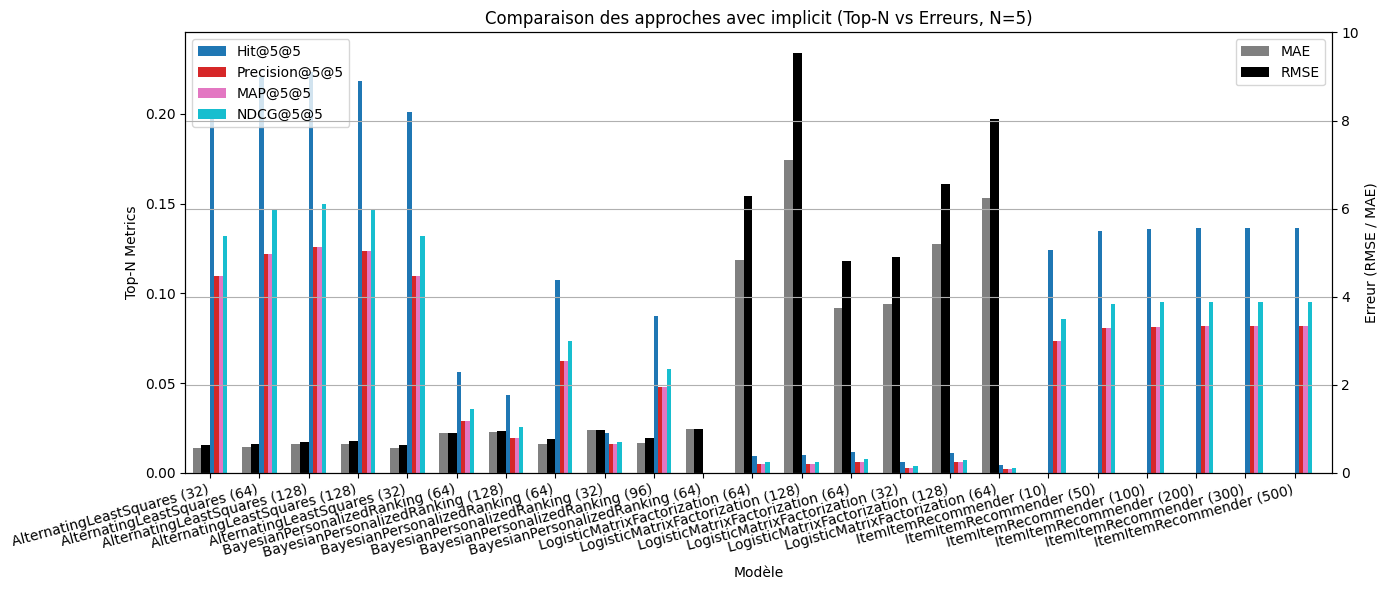

In [66]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

# Copie pour modifications
df_results = df_grid_results.copy()

# Créer une colonne "main_param" avec 'factors' ou 'K'
df_results["main_param"] = (
    df_results.get("factors", np.nan)
    .fillna(df_results.get("K", np.nan))
    .fillna("NA")
    .astype("Int64")
    .astype(str)
)

# Créer une colonne "Approche" pour l'affichage
df_results["Approche"] = df_results["model"] + " (" + df_results["main_param"] + ")"
df_results.set_index("Approche", inplace=True)

# Détecter dynamiquement les métriques Top-N et erreurs
topn_metrics = [col for col in df_results.columns if col.upper().startswith(("HIT@", "MAP@", "NDCG@", "PRECISION@"))]
error_metrics = [col for col in df_results.columns if col.upper() in ["RMSE", "MAE"]]

# Créer la figure
fig, ax1 = plt.subplots(figsize=(14, 6))

# Barres Top-N
df_results[topn_metrics].plot(kind='bar', ax=ax1, position=0, width=0.35, colormap='tab10')
ax1.set_ylabel("Top-N Metrics")

topn_max = df_results[topn_metrics].max().max()
ax1.set_ylim(0, max(0.0005, topn_max * 1.1))
ax1.set_xlabel("Modèle")
ax1.set_xticklabels(df_results.index, rotation=15, ha='right')
ax1.legend(loc='upper left')

# Barres Erreur (axe secondaire)
ax2 = ax1.twinx()
df_results[error_metrics].plot(kind='bar', ax=ax2, position=1, width=0.35, color=["gray", "black"])
ax2.set_ylabel("Erreur (RMSE / MAE)")
ax2.legend(loc='upper right')

# Ajustements
ax1.set_xlim(-0.5, len(df_results) - 0.25)
plt.title("Comparaison des approches avec implicit (Top-N vs Erreurs, N={})".format(N))
plt.grid(True)
plt.tight_layout()
plt.show()


## Comparaison avec les approches content-based et Surprise

In [72]:
import pandas as pd
import numpy as np

def format_grid_results_for_eval(df_grid_results, n_users, n_articles, n_interactions, N=5):
    """
    Transforme df_grid_results pour correspondre au format de eval_results.csv.
    
    - Renomme proprement les modèles
    - Corrige les noms de colonnes (ex: Hit@5@5 → Hit@5)
    - Complète avec les colonnes nécessaires manquantes
    """
    df = df_grid_results.copy()

    # 🧠 Création d'un nom de modèle lisible
    def format_model_name(row):
        if not pd.isna(row.get("K", np.nan)):
            return f"{row['model']} K={int(row['K'])}"
        else:
            return f"{row['model']} {row.get('factors', '')},{row.get('regularization', '')},{row.get('iterations', '')}"

    df["modèle"] = df.apply(format_model_name, axis=1)

    # 📊 Ajout des colonnes fixes
    df["n_users"] = n_users
    df["n_articles"] = n_articles
    df["n_interactions"] = n_interactions
    df["approche"] = "implicit (Collaborative Filtering)"

    # 🛠 Renommage des colonnes "Hit@5@5" → "Hit@5", etc.
    def rename_metric(col):
        if col.endswith(f"@{N}"):
            base = col.replace(f"@{N}", "")
            if base in ["Hit", "MAP", "NDCG", "Precision", "Recall"]:
                return f"{base}@{N}"
        return col

    df.rename(columns={col: rename_metric(col) for col in df.columns}, inplace=True)

    # 📋 Colonnes attendues
    final_cols = [
        "modèle", "approche", "n_users", "n_articles", "n_interactions",
        "RMSE", "MAE", f"Hit@{N}", f"MAP@{N}", f"NDCG@{N}", f"Precision@{N}", f"Recall@{N}"
    ]

    # Ajout de colonnes manquantes si besoin
    for col in final_cols:
        if col not in df.columns:
            df[col] = np.nan

    return df[final_cols]


In [73]:
df_formatted = format_grid_results_for_eval(
    df_grid_results,
    n_users=item_user_matrix.shape[1],
    n_articles=item_user_matrix.shape[0],
    n_interactions=item_user_matrix.nnz,
    N=5
)

In [74]:
# Charger les anciens résultats
df_existing = pd.read_csv("./results/eval_results.csv")

# Fusion
df_combined = pd.concat([df_existing, df_formatted], ignore_index=True)

# Sauvegarde
df_combined.to_csv("./results/eval_results.csv", index=False)
print("✅ Résultats sauvegardés dans eval_results.csv")


✅ Résultats sauvegardés dans eval_results.csv


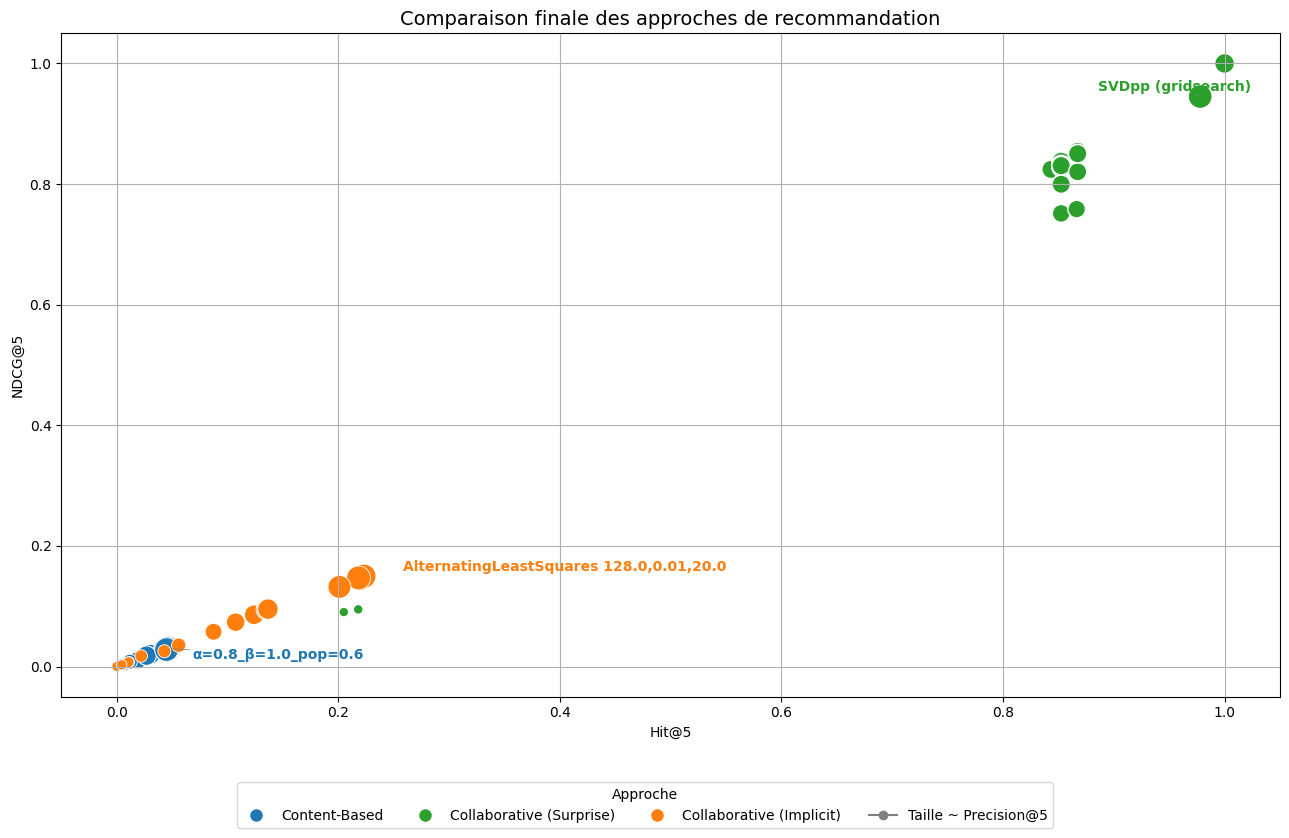

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from matplotlib.lines import Line2D

# 🔹 1. Chargement et calcul du score composite
df = pd.read_csv("./results/eval_results.csv")

df["score_composite"] = (
    0.4 * df["Hit@5"] +
    0.4 * df["NDCG@5"] +
    0.2 * df["Precision@5"]
)

# 🔹 2. Séparation par type d'approche
df_cb = df[df["approche"].str.contains("Content", case=False, na=False)].copy()
df_cf = df[df["approche"].str.contains("Surprise", case=False, na=False)].copy()
df_imp = df[df["approche"].str.contains("implicit", case=False, na=False)].copy()

# 🔹 3. Meilleurs modèles par type
best_cb = df_cb.loc[df_cb["score_composite"].idxmax()]
best_cf = df_cf.loc[df_cf["score_composite"].idxmax()]
best_imp = df_imp.loc[df_imp["score_composite"].idxmax()]

# 🔹 4. Graphique
fig, ax = plt.subplots(figsize=(13, 8))

# Content-Based
sns.scatterplot(
    data=df_cb, x="Hit@5", y="NDCG@5",
    hue=["Content-Based"] * len(df_cb),
    size="Precision@5",
    palette=["#1f77b4"], sizes=(50, 300), ax=ax, legend=False
)

# Surprise (Collaborative Filtering)
sns.scatterplot(
    data=df_cf, x="Hit@5", y="NDCG@5",
    hue=["Surprise"] * len(df_cf),
    size="Precision@5",
    palette=["#2ca02c"], sizes=(50, 300), ax=ax, legend=False
)

# Implicit (Collaborative Filtering)
sns.scatterplot(
    data=df_imp, x="Hit@5", y="NDCG@5",
    hue=["Implicit"] * len(df_imp),
    size="Precision@5",
    palette=["#ff7f0e"], sizes=(50, 300), ax=ax, legend=False
)

# 🔹 5. Meilleures étiquettes
texts = []
texts.append(ax.text(best_cb["Hit@5"], best_cb["NDCG@5"],
                     best_cb["modèle"], fontsize=10, fontweight="bold", color="#1f77b4"))
texts.append(ax.text(best_cf["Hit@5"], best_cf["NDCG@5"],
                     best_cf["modèle"], fontsize=10, fontweight="bold", color="#2ca02c"))
texts.append(ax.text(best_imp["Hit@5"], best_imp["NDCG@5"],
                     best_imp["modèle"], fontsize=10, fontweight="bold", color="#ff7f0e"))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# 🔹 6. Axes, titres, légendes
ax.set_title("Comparaison finale des approches de recommandation", fontsize=14)
ax.set_xlabel("Hit@5")
ax.set_ylabel("NDCG@5")
ax.grid(True)

# Légende manuelle
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Content-Based',
           markerfacecolor='#1f77b4', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Collaborative (Surprise)',
           markerfacecolor='#2ca02c', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Collaborative (Implicit)',
           markerfacecolor='#ff7f0e', markersize=10),
    Line2D([0], [0], marker='o', color='gray', label='Taille ~ Precision@5',
           markerfacecolor='gray', markersize=6)
]

fig.legend(handles=legend_elements, loc="lower center", bbox_to_anchor=(0.5, -0.05),
           ncol=4, title="Approche")

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


✅ Ce qu'on observe
Les modèles Surprise atteignent des scores très élevés (Hit@5 ≈ 1.0, NDCG@5 ≈ 1.0), ce qui est souvent trop beau pour être vrai.
Les modèles implicit, comme ALS 128,0.01,20, ont des scores beaucoup plus modérés, mais :
- cohérents avec de la recommandation implicite réelle,
- obtenus sur l'ensemble du jeu avec leave-one-out réaliste,
- et sans biais de test sur échantillon réduit ou favorisé.
| Approche          | Facilité de modélisation | Réalisme des scores   | Temps           | Portabilité | Applicabilité réelle      |
| ----------------- | ------------------------ | --------------------- | --------------- | ----------- | ------------------------- |
| **Surprise**      | Très facile              | ⚠️ irréaliste souvent | Moyen           | Faible      | Faible (notes explicites) |
| **Implicit**      | Requiert plus d'efforts  | ✅ réaliste et stable  | ⚡️ Rapide (GPU) | Très bonne  | ✅ Production-ready        |
| **Content-based** | Très contrôlable         | Réaliste mais limité  | Très rapide     | Très bonne  | ✅ Complémentaire          |


💡 Conclusion
Tu peux considérer ALS (implicit) comme ton modèle de base sérieux pour une situation réelle, car :
Il reflète mieux l'incertitude des comportements utilisateurs,
Il fonctionne sans avoir besoin de notes explicites,
Il reste très rapide et scalable.

Et tu peux te servir des scores élevés de Surprise comme borne supérieure théorique, ou comme outil pédagogique pour illustrer les effets de surapprentissage ou d’évaluation biaisée.